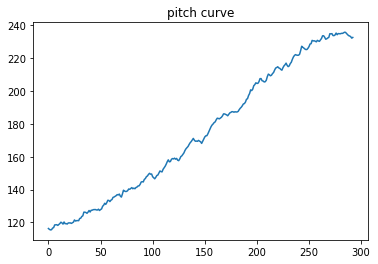

(294,) 294
293
pitch score : 22.538353687933313 fail
note_range : 12.370316332394527 fail


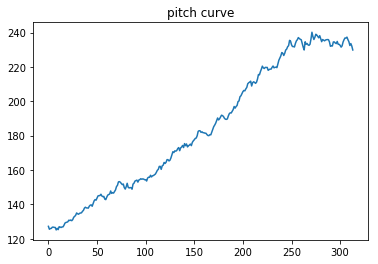

(315,) 315
314
pitch score : 25.495274100180957 fail
note_range : 11.288355656412762 fail


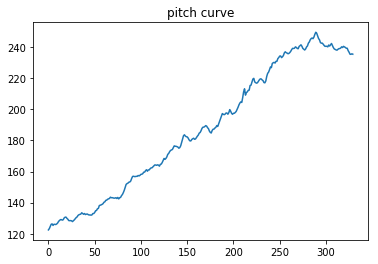

(331,) 331
330
pitch score : 29.072455709262716 fail
note_range : 12.317608262555183 fail


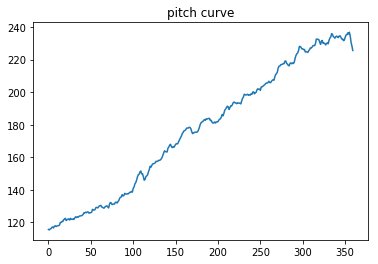

(361,) 361
360
pitch score : 23.254414291159836 fail
note_range : 12.448711542074918 fail


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2


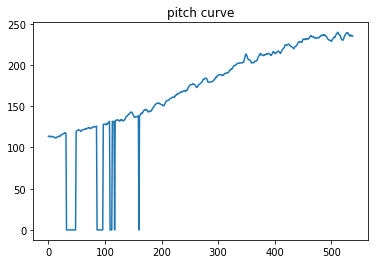

(540,) 540
539
pitch score : inf fail
note_range : inf fail


In [38]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse
import sys
import numpy as np

import matplotlib      # Remove this line if you don't need them
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import soundfile as sf
# import librosa
import pyworld as pw

aiueo = ['a','i','u','e','o']
D3_note = 30
pitch_score_threshold = 0.6
note_range_threshold = 0.7

frame_period = 10.0 # millisecond
samples_per_frame = int(np.floor(44100.0 * frame_period/1000.0))

def print_judge(name,val,thres):
    print(name,":",val,"pass" if val<thres else "fail")

for i in range(1,6):

    wavname = 'vowel/'+aiueo[i-1]+'_gliss'
    x, fs = sf.read(wavname+'.wav')

    try:
        x = (x[10000:,0] + x[10000:,1])/2 # stereo to mono
        x = x/max(x)
    
    except:
        print("Error: Please use 2 channels stereo format for recording")
        sys.exit()
    num_of_frames = int(np.floor(len(x)/samples_per_frame))    
    f0, sp, ap = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options
    
#   pitch judgement
    f0_note = 12*np.log2(f0[1:-1]/440)+49
    pitch_score =  np.mean(np.power(f0_note-D3_note,2))
    note_range = np.ptp(f0_note)
#     plt.plot(f0_note-D3_note)
    plt.plot(f0[1:-1])
    plt.title("pitch curve")
    plt.show()
    
#   Amplitude judgement
    AMP = np.zeros(int(np.floor(len(x)/samples_per_frame)))
    print(AMP.shape,num_of_frames)
    for i in range(0,num_of_frames,1):
        AMP[i] = np.mean(np.power(x[i*samples_per_frame:i*samples_per_frame+samples_per_frame],2))

    print(i)
    print_judge("pitch score",pitch_score,pitch_score_threshold)
    print_judge("note_range",note_range,note_range_threshold)
    

NameError: name 'x' is not defined

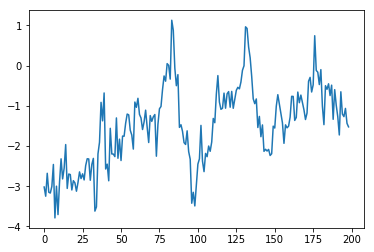

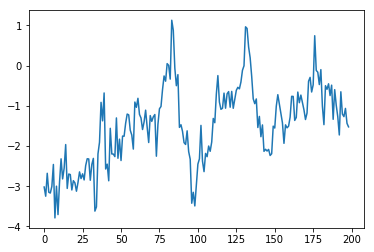

3.247199755285228 1.8897863703583653


In [17]:
f0_note = 12*np.log2(f0[1:-1]/440)
pitch_score =  np.mean(np.power(f0_note-D3_pit,2))
note_delta_max = max(abs(f0_note[1:]-f0_note[:-1]))
plt.plot(f0[1:-1]-D3_pit)
plt.show()
print(f0_score,f0_delta_max)

In [25]:
print(f0_note)

[-19.42775693 -19.58527419 -19.69302006 -19.62091852 -19.4210402
 -19.31067768 -19.27543962 -19.15245373 -18.99584008 -18.75823657
 -18.79791845 -18.83242273 -18.71542945 -18.57390311 -18.48189709
 -18.57199197 -18.69248944 -18.86828182 -18.97713615 -19.07382897
 -19.08677728 -19.18572264 -19.31992613 -19.29012249 -19.21279491
 -19.20217527 -19.18435381 -19.21416176 -19.26692476 -19.25558586
 -19.30323589 -19.27378493 -19.24075996 -19.2426039  -19.23552635
 -19.15118283 -19.23685388 -19.17334694 -19.2817136  -19.45087259
 -19.44936491 -19.32273614 -19.26400167 -19.21707535 -19.21563999
 -19.15376573 -19.15691856 -19.21847523 -19.14575448 -19.08790613
 -19.15373584 -19.07346469 -19.18733375 -19.18406611 -19.10352229
 -19.03858449 -19.09711529 -19.17789925 -19.20699824 -19.19349822
 -19.10187495 -19.03145249 -19.00579144 -19.05767105 -19.08564537
 -18.95789939 -19.10614009 -19.04302567 -19.02770459 -18.97969672
 -19.02447019 -19.1614378  -19.16607658 -19.23877716 -19.07630655
 -19.017316